# **텍스트 분류 모델 파인 튜닝하기**

# **1. 환경준비**

## (1) 라이브러리 설치


In [1]:
!pip install transformers==4.31.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00


* 설치후 세션 재시작

## (2) 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset  # 데이터셋 다운로드


## (3) 데이터셋 다운로드

* emotions 데이터셋 소개
    * 트위터 글(텍스트) 기반의 감정 분류를 위한 데이터셋
    * 데이터셋 구조
        * text: 감정을 분석할 텍스트 데이터.
        * label: 'sadness', 'joy', 'love', 'anger', 'fear', 'surprise'
        * input_ids와 attention_mask: transformers 라이브러리와 함께 모델을 학습시킬 때 사용되는, 텍스트를 모델이 처리할 수 있는 형태로 인코딩한 값들입니다.
        * train 16,000건, val 2,000건, test 2,000건

In [4]:
# emotion 데이터셋 다운로드
imdb = load_dataset("imdb")

# # 데이터 줄이기
imdb["train"] = imdb["train"].shuffle(seed=42).select(range(10000))
imdb["test"] = imdb["test"].shuffle(seed=42).select(range(3000))
imdb["unsupervised"] = imdb["unsupervised"].shuffle(seed=42).select(range(1))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
# 데이터 구조
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 1
    })
})

In [6]:
# 데이터 레이블
classes = imdb['train'].features['label'].names
classes

['neg', 'pos']

# **2.데이터 둘러보기**

## (1) 데이터 프레임으로 변환

In [11]:
# 데이터프레임으로 변환
imdb.set_format(type="pandas")

# train 데이터 만 추출
df = imdb["train"][:]

# 정수인코딩된 레이블에 원래 문자 추가하기
def label_int2str(row):
    return imdb["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,There is no relation at all between Fortier an...,1,pos
1,This movie is a great. The plot is very true t...,1,pos
2,"George P. Cosmatos' ""Rambo: First Blood Part I...",0,neg
3,In the process of trying to establish the audi...,1,pos
4,"Yeh, I know -- you're quivering with excitemen...",0,neg


## (2) 클래스 분포 살펴보기

In [12]:
df['label_name'].value_counts()

neg    5004
pos    4996
Name: label_name, dtype: int64

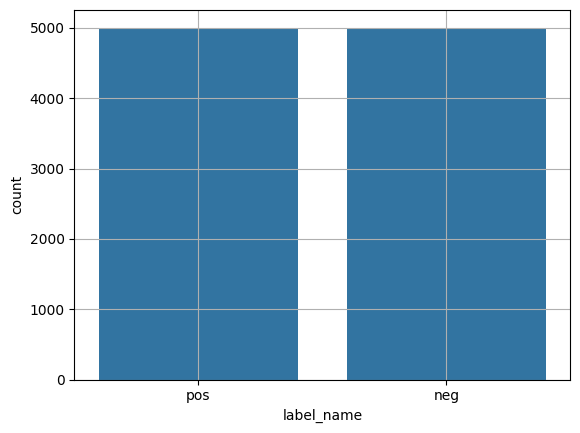

In [13]:
sns.countplot(x = 'label_name', data = df)
plt.grid()
plt.show()

## (3) 트윗 문장 길이(단어 수) 분포 확인

* 트랜스포머 모델은 최대 문맥 길이라는 최대 입력 시퀀스 길이가 있음
* DistilBERT 는 최대 문맥 크기가 512 토큰.
* 토큰을 단어단위로 간주할 때, 트윗당 단어 분포

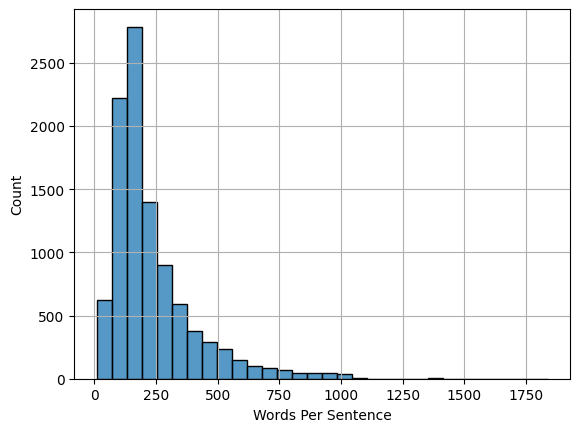

In [14]:
df["Words Per Sentence"] = df["text"].str.split().apply(len)
sns.histplot(x = 'Words Per Sentence', data = df, bins = 30)
plt.grid()
plt.show()

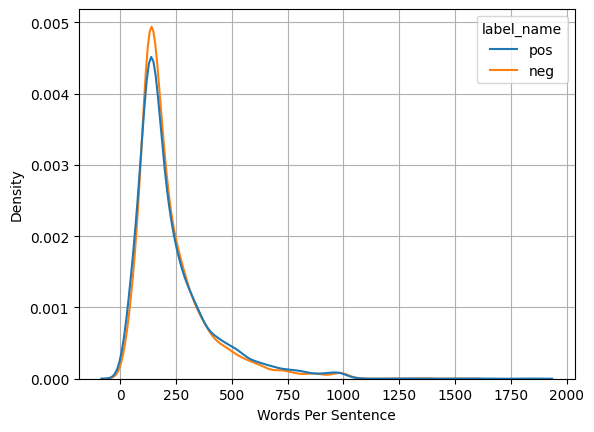

In [15]:
sns.kdeplot(x = 'Words Per Sentence', data = df, hue = 'label_name', common_norm = False)
plt.grid()
plt.show()

* 이제 더이상 데이터프레임 포멧이 필요하지 않으니 원본으로 되돌려 놓자.

In [16]:
imdb.reset_format()

# **3.데이터 준비**

* BERT에서 사용되는 토크나이즈 WordPiece
* AutoTokenizer 클래스 : 체크포인트 이름을 사용해 모델의 설정, 사전훈련된 가중치, 어휘사전을 자동으로 추출


In [7]:
from transformers import AutoTokenizer

## (1) 토크나이저 다운로드
* bert 모델 학습시 생성된 토크나이저 다운로드

In [8]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

* 모델 입력을 위한 필드 이름

In [9]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

## **(2) 데이터셋 토큰화**

In [24]:
# 문장 하나씩 토크나이즈 하기 위한 함수 생성
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=256)

* map 매서드는 말뭉치에 있는 모든 샘플을 개별적으로 적용.

In [25]:
imdb_encoded = imdb.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [26]:
imdb_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1
    })
})

In [27]:
# 데이터 한건에 대한 내용을 살펴봅시다.
col_names = imdb_encoded["train"].column_names
sample_data = imdb_encoded["train"][0]
for i in col_names :
    print(i + ' :', sample_data[i])

text : There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it's the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...
label : 1
input_ids : [101, 2045, 2003, 2053, 7189, 2012, 2035, 2090, 3481, 3771, 1998, 6337, 2099, 2021, 1996, 2755, 2008, 2119, 2024, 2610, 2186, 2055, 6355, 6997, 1012, 6337, 2099, 3504, 15594, 2100, 1010, 3481, 3771, 3504, 4438, 1

## (3) 텐서플로 학습을 위한 데이터 구성

In [28]:
imdb_encoded["train"]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 10000
})

In [14]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [29]:
# 배치에 포함될 샘플의 수
batch_size = 64

# 필요한 칼럼 : ['input_ids', 'attention_mask']
token_cols = tokenizer.model_input_names

# 데이터셋 구성
train = imdb_encoded["train"].to_tf_dataset(columns=token_cols, label_cols="label",
                                          shuffle=True, batch_size=batch_size)

test = imdb_encoded["test"].to_tf_dataset(columns=token_cols, label_cols="label",
                                        shuffle=False, batch_size=batch_size)

In [23]:
train

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# **4.파인튜닝**

In [18]:
from transformers import TFAutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
from keras.optimizers import Adam
from sklearn.metrics import *

## **(1) 사전 훈련된 모델 로드하기**

* 이진 분류 : 클래스 수 2
* loss : binary_crossentropy

In [37]:
# 사전훈련된 모델 지정
preTrModel = "distilbert-base-uncased"

# Output Layer 노드 수
nclass = 2

# 모델 로드하기
model_ft = TFAutoModelForSequenceClassification.from_pretrained(preTrModel, num_labels=nclass)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

## **(2) 추가 학습**


In [ ]:
# 컴파일 및 학습
model_ft.compile(optimizer = Adam(5e-5), loss = 'binary_crossentropy')
model_ft.fit(train, validation_data = test, epochs=5, batch_size = 64)

Epoch 1/5
313/313 [==============================] - 348s 900ms/step - loss: 0.7297 - val_loss: 0.3964
Epoch 2/5
188/313 [=================>............] - ETA: 1:42 - loss: 0.3950

## **(3) 예측 및 평가**

In [32]:
pred = model_ft.predict(test)
pred = pred.logits.argmax(axis=1)

94/94 [==============================] - 26s 272ms/step


In [34]:
y_test = imdb_encoded["test"]['label']

In [35]:
print(confusion_matrix(y_test, pred))
print()
print(classification_report(y_test, pred, target_names = classes))

[[1184  327]
 [ 106 1383]]

              precision    recall  f1-score   support

         neg       0.92      0.78      0.85      1511
         pos       0.81      0.93      0.86      1489

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.85      3000



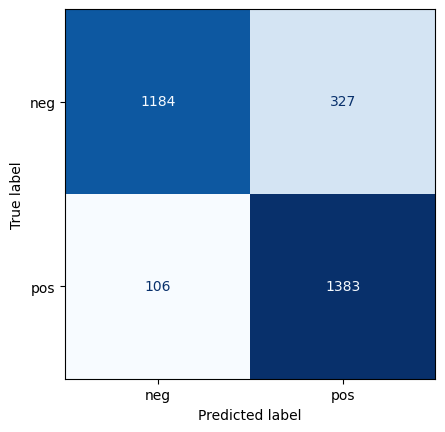

In [36]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, colorbar=False)
    plt.show()

plot_confusion_matrix(y_test, pred, classes)